In [53]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from mne.io import concatenate_raws
import pandas as pd

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC

In [5]:
import mne
from mne.datasets.sleep_physionet.age import fetch_data

# 1. Obtenção de dados

Na abordagem inicial, os conjuntos de treino e teste foram criados manualmente. 
25 sujeitos foram utilizados para constituir o conjunto de treino, e 10 para o conjunto de teste.

In [6]:
subjects_train =list(range(25))
subjects_test = list(range(25, 35))
sub_train =  fetch_data(subjects = subjects_train, recording=[1])
sub_test =  fetch_data(subjects = subjects_test, recording=[1])

Using default location ~/mne_data for PHYSIONET_SLEEP...
Using default location ~/mne_data for PHYSIONET_SLEEP...


In [7]:
# identificação dos eventos
events_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 5,
    "Sleep stage R": 6}

## 2. Processamento de dados

**Signal_stage function** - atribui os estados, para cada paciente 

In [39]:
def signal_stage(subjects, sub):
     # guarda todos os sinais originais
    signal_EEG = [None] * len(subjects)
    signal_EOG = [None] * len(subjects) # estes são os sinais que pretendemos, para cada utilizador
    annot = [None] * len(subjects) #anotções dos sinais

    events_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 5,
    "Sleep stage R": 6}


    for i in range(0, len(subjects)):

        input= sub[i]

        #file reading
        signal =  mne.io.read_raw_edf(
            input[0],
            stim_channel="Event marker",
            infer_types=True,
            preload=True,
            verbose="error"  
        )

        #channel selection - only EEG
        signal_EEG[i] = signal.pick(["eeg"]).load_data()

        # setting a reference for EEG to lessen the artifacts
        signal_EEG[i].set_eeg_reference("average", projection=True)
        annot[i] =  mne.read_annotations(input[1])

        signal_EEG[i].set_annotations(annot[i], emit_warning=False)
        
    
    return(signal_EEG, annot)

In [40]:
[x_train, Annot_train] = signal_stage(subjects_train, sub_train)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projecti

**an example: for subject nº 2**

In [42]:
x_train[1].info

Measurement date,"March 29, 1989 16:49:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,2 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.00 Hz
Lowpass,50.00 Hz


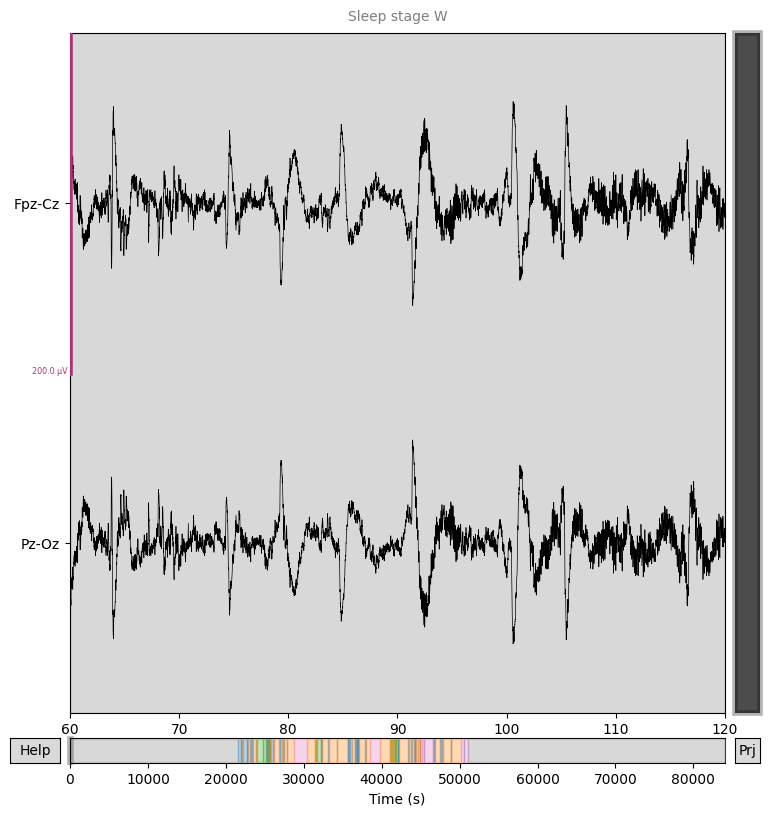

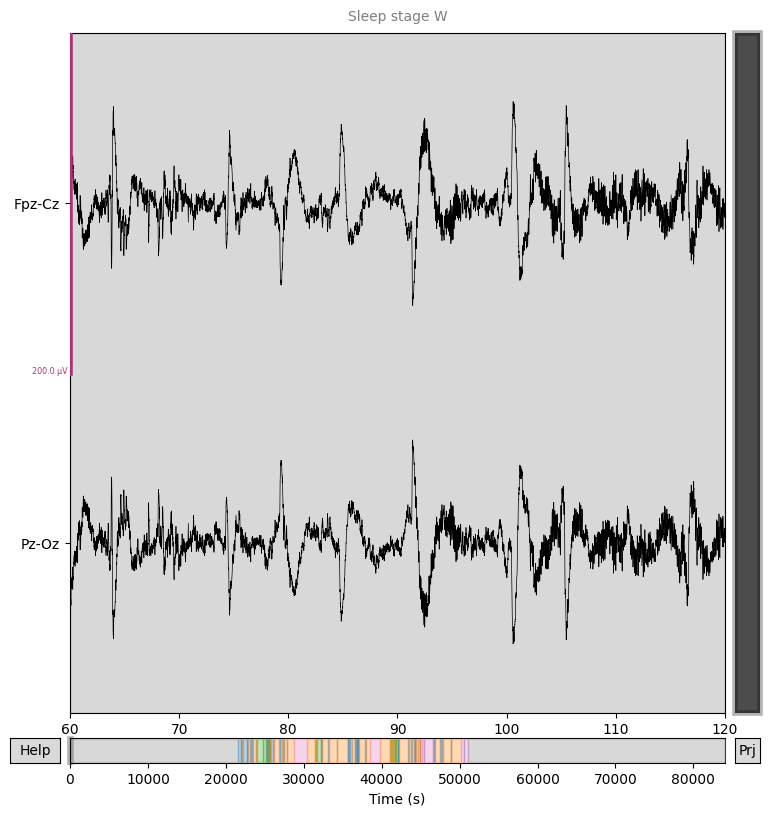

In [43]:
x_train[1].plot(
    start=60,
    duration=60,
    scalings=dict(eeg=1e-4),
)

In [44]:
[x_test, Annot_test] = signal_stage(subjects_test, sub_test)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projecti

In [ ]:
del sub_train
del sub_test

**Signal Representation** - representa os sinais

In [18]:
x_test[4]

Measurement date,"September 16, 1991 15:22:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,2 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.00 Hz
Lowpass,50.00 Hz


In [46]:
def signal_event (subjects, signal, annot):
    events_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 5,
    "Sleep stage R": 6}

    event_signal = [None] * len(subjects) 
    for i in range(0, len(subjects)):
        # removal of the last 30 minutes of wake events before sleep and after sleep
        annot[i].crop(annot[i][1]["onset"] - 30 * 60, annot[i][-2]["onset"] + 30 * 60) 
        signal[i].set_annotations(annot[i], emit_warning=False)


        # 30 seconds epochs
        event_signal[i], _ = mne.events_from_annotations(
        signal[i], event_id=events_id, chunk_duration=30.0)
        
    return(event_signal)

        
        
    

In [47]:
events_train = signal_event(subjects_train,x_train, Annot_train)
events_test = signal_event(subjects_test,x_test, Annot_test)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 

**exemplo: paciente nº 2 novamente** - _localização temporal de eventos

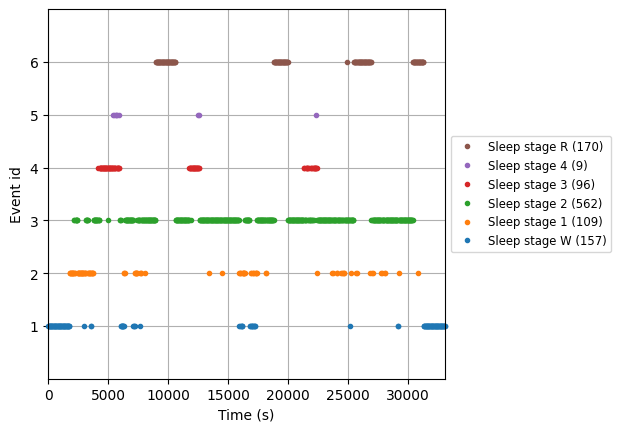

In [51]:
fig = mne.viz.plot_events(
    events_train[1],
    event_id=events_id,
    sfreq=x_train[1].info["sfreq"],
    first_samp=events_train[1][0, 0],
)

# 3. Definição de epochs para treino de modelo

In [52]:
def signal_epochs(subjects,signal,event_signal ):
    
    events_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 5,
    "Sleep stage R": 6}

    epochs = [None] * len(subjects)

    for i in range(0, len(subjects)):
        tmax = 30.0 - 1.0 / signal[i].info["sfreq"] 

        epochs[i] = mne.Epochs(
            raw=signal[i],
            events=event_signal[i],
            event_id=events_id,
            tmin=0.0,
            tmax=tmax,
            baseline=None, 
            on_missing = "ignore"
        )
    epochs = mne.concatenate_epochs(epochs)
    return(epochs)


In [ ]:
epoch_train = signal_epochs(subjects_train,x_train,events_train)
epoch_test= signal_epochs(subjects_test,x_test,events_test)

Not setting metadata
836 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
1087 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
1020 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
950 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
1234 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
670 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
827 matching events found
No baseline co

/var/folders/l_/hg8v1x2n6sn481rmk8n90ftw0000gn/T/ipykernel_69658/3137360300.py:25: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs)


0 bad epochs dropped
Using data from preloaded Raw for 1020 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 950 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1234 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 670 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 827 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 969 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1127 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1130 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1097 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 924 events and 3000 original time points

/var/folders/l_/hg8v1x2n6sn481rmk8n90ftw0000gn/T/ipykernel_69658/3137360300.py:25: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs)


0 bad epochs dropped
Using data from preloaded Raw for 1027 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1123 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1128 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 919 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1028 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1518 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1886 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1480 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 949 events and 3000 original time points ...
Using data from preloaded Raw for 1591 events and 3000 original time points ...
Using data fr

In [ ]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5 * n_channels]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))


    return np.concatenate(X, axis=1)

# 4 Construção de um classificador

## A. Decision Tree Classifier

In [ ]:
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [ ]:
y_train = epoch_train.events[:,2]
y_test = epoch_test.events[:, 2]

In [ ]:
pipe1 = make_pipeline( FunctionTransformer(eeg_power_band, validate=False), StandardScaler(),DecisionTreeClassifier(criterion='gini', splitter='random',max_depth=10)) 
m_DC = pipe1.fit(epoch_train, y_train)


y_predDC = m_DC.predict(epoch_train)
y_test_predDC = m_DC.predict(epoch_test)



    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


In [ ]:
CR_DC = classification_report(y_test, y_test_predDC, target_names=events_id.keys())

print(CR_DC)

               precision    recall  f1-score   support

Sleep stage W       0.79      0.86      0.83      4091
Sleep stage 1       0.24      0.09      0.13      1430
Sleep stage 2       0.76      0.80      0.78      4663
Sleep stage 3       0.35      0.33      0.34       453
Sleep stage 4       0.49      0.32      0.39       232
Sleep stage R       0.46      0.57      0.51      1780

     accuracy                           0.68     12649
    macro avg       0.52      0.49      0.50     12649
 weighted avg       0.65      0.68      0.66     12649



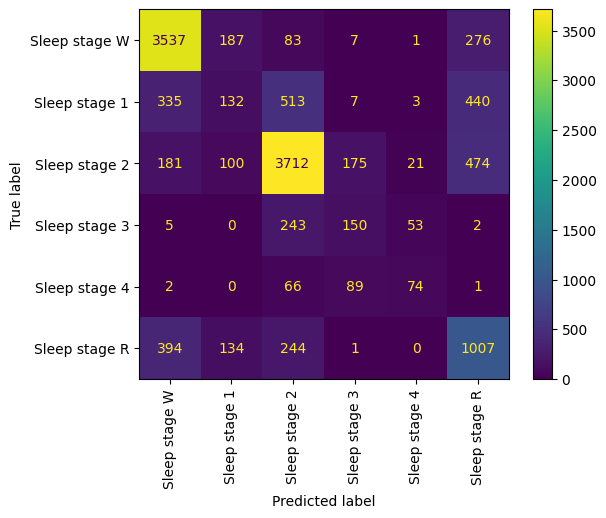

In [ ]:
cmDC = confusion_matrix(y_test, y_test_predDC, labels =m_DC.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cmDC, display_labels=events_id.keys())
disp.plot()
plt.xticks(rotation=90)
plt.show()


## B. Random Forest 

In [ ]:
pipe2 = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False), StandardScaler(),
   RandomForestClassifier(n_estimators=100, random_state=42,bootstrap=True)
)
m_RF = pipe2.fit(epoch_train, y_train)


y_predRF = m_RF.predict(epoch_train)
y_test_predRF = m_RF.predict(epoch_test)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


In [ ]:
CR_RF = classification_report(y_test, y_test_predRF, target_names=events_id.keys())

print(CR_RF)

               precision    recall  f1-score   support

Sleep stage W       0.79      0.88      0.83      4091
Sleep stage 1       0.23      0.11      0.15      1430
Sleep stage 2       0.76      0.81      0.78      4663
Sleep stage 3       0.31      0.19      0.24       453
Sleep stage 4       0.39      0.31      0.35       232
Sleep stage R       0.50      0.54      0.52      1780

     accuracy                           0.69     12649
    macro avg       0.50      0.48      0.48     12649
 weighted avg       0.65      0.69      0.66     12649



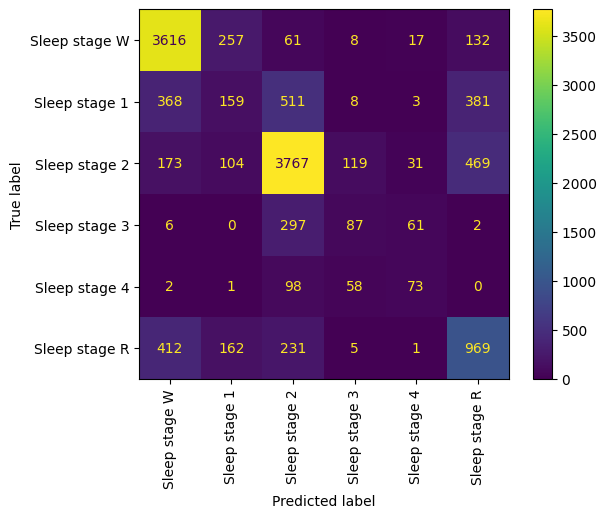

In [ ]:
cmRF = confusion_matrix(y_test, y_test_predRF, labels =m_RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cmRF, display_labels=events_id.keys())
disp.plot()
plt.xticks(rotation=90)
plt.show()


## C. SVC

In [ ]:
pipe3 = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False),StandardScaler(),
   SVC(C=0.5, degree=4, gamma='scale')
)
m_SVC = pipe3.fit(epoch_train, y_train)

    Using multitaper spectrum estimation with 7 DPSS windows


In [ ]:
y_predSVC = m_SVC.predict(epoch_train)
y_test_predSVC = m_SVC.predict(epoch_test)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


In [ ]:
CR_SVC = classification_report(y_test, y_test_predSVC, target_names=events_id.keys())

print(CR_SVC)

               precision    recall  f1-score   support

Sleep stage W       0.80      0.92      0.86      4091
Sleep stage 1       0.28      0.06      0.09      1430
Sleep stage 2       0.77      0.80      0.78      4663
Sleep stage 3       0.31      0.19      0.23       453
Sleep stage 4       0.46      0.31      0.37       232
Sleep stage R       0.47      0.63      0.54      1780

     accuracy                           0.70     12649
    macro avg       0.51      0.48      0.48     12649
 weighted avg       0.66      0.70      0.67     12649



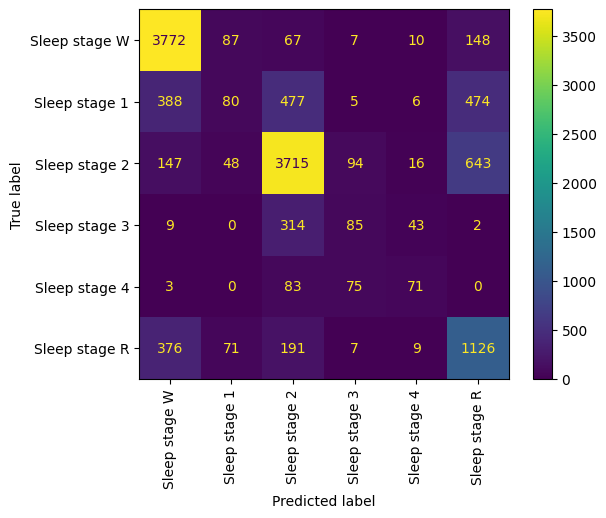

In [ ]:
cmSVC= confusion_matrix(y_test, y_test_predSVC, labels =m_SVC.classes_)
dispSVC = ConfusionMatrixDisplay(confusion_matrix=cmSVC, display_labels=events_id.keys())
dispSVC.plot()
plt.xticks(rotation=90)
plt.show()

